In [146]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, Normalizer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load in the data
train_data = pd.read_csv('./training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


## Variable exploration (part I)

Looking at the variables to understand the type of data I'm working with.

* V1 and V4-7 have a small number of integer values, and can probably be treated as categorical. A few to keep an eye on:
    * V5, level 4 is a bit rare
    * V6 is extremely uniform across the population
* V2 is normally distributed, V3 is uniformly distributed

In [235]:
for var in ['Promotion', 'V1', 'V4', 'V5', 'V6', 'V7']:
    print(train_data.loc[train_data.Promotion=='Yes'].groupby(var).purchase.mean())

Promotion
Yes    0.017019
Name: purchase, dtype: float64
V1
0    0.018550
1    0.015957
2    0.018994
3    0.012804
Name: purchase, dtype: float64
V4
1    0.006985
2    0.021764
Name: purchase, dtype: float64
V5
1    0.020316
2    0.010264
3    0.021865
4    0.016976
Name: purchase, dtype: float64
V6
1    0.017779
2    0.016045
3    0.017886
4    0.016372
Name: purchase, dtype: float64
V7
1    0.018011
2    0.016597
Name: purchase, dtype: float64


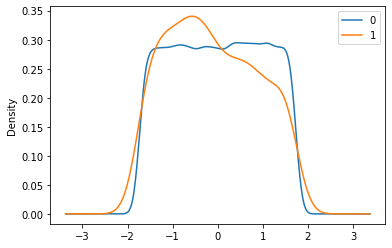

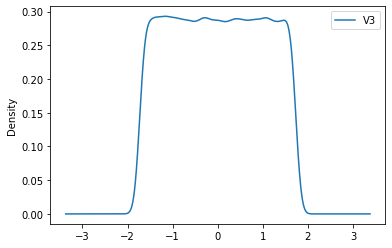

,V2,V3
count,84534.000000,84534.000000
mean,29.973600,0.000190
std,5.010626,1.000485
min,7.104007,-1.684550
25%,26.591501,-0.905350
50%,29.979744,-0.039572
75%,33.344593,0.826206
max,50.375913,1.691984


In [241]:
train_data.loc[train_data.Promotion=='Yes'].groupby('purchase').V3.plot(kind='density', legend=True)
plt.show()
train_data.V3.plot(kind='density', legend=True)
plt.show()
train_data.loc[:, ['V2', 'V3']].describe()

## Starting performance

Sending the promotion to everyone increases purchases by 0.95 pp, but has a net effect on revenue of -$2334.60. I think we can do better!

In [ ]:
p_buy = train_data.loc[(train_data.purchase == 1) & (train_data.Promotion == 'Yes')].shape[0]
p_all = train_data.loc[train_data.Promotion == 'Yes'].shape[0]
c_buy = train_data.loc[(train_data.purchase == 1) & (train_data.Promotion == 'No')].shape[0]
c_all = train_data.loc[train_data.Promotion == 'No'].shape[0]

In [ ]:
iir = (p_buy/p_all) - (c_buy/c_all)
print(f"IRR: {iir}")
nir = (p_buy * 10) - (p_all * 0.15) - (c_buy * 10)
print(f"NIR: {nir}")

In [ ]:
p_buy * 10

## Variable exploration (part II)

For completeness, I should check that the variables are all divided evenly between the treatment and control groups.
TODO

## Data prep

Need to set up data transformation pipeline. This seems like a reasonable set for which to use 
* Purchases are rare, so I need to make sure the training and test sets have similar frequencies of them
* There's a combination of categorical and continuous data
    * Use One Hot Encoder for categorical
Transform as needed (OHE for categories, normalize continuous)
* Set up pipeline

In [2]:
Xt = train_data.loc[train_data.Promotion == 'Yes'].drop(['Promotion', 'purchase'], axis=1)
yt = train_data.loc[train_data.Promotion == 'Yes'].purchase
Xc = train_data.loc[train_data.Promotion == 'No'].drop(['Promotion', 'purchase'], axis=1)
yc = train_data.loc[train_data.Promotion == 'No'].purchase

X_train, X_test, y_train, y_test = train_test_split(
    Xt, yt, test_size = 0.2, random_state=49300, stratify=yt)

In [182]:
def nir_scor(y_act, y_pred):
    vals = pd.DataFrame({'pred':y_pred, 'act':y_act})
    
    p_buy = vals.loc[(vals.pred == 1)].act.sum()
    p_all = vals.loc[(vals.pred == 1)].shape[0]
    c_buy = vals.loc[(vals.pred == 0)].act.sum()
    c_all = vals.loc[(vals.pred == 0)].shape[0]    
    
    iir = (p_buy/p_all) - (c_buy/c_all)
    nir = (p_buy * 10) - (p_all * 0.15) - (c_buy * 10)
    
    return nir

nir_scorf = metrics.make_scorer(nir_scor, greater_is_better=True)

def iir_scor(y_act, y_pred):
    vals = pd.DataFrame({'pred':y_pred, 'act':y_act})
    
    p_buy = vals.loc[(vals.pred == 1)].act.sum()
    p_all = vals.loc[(vals.pred == 1)].shape[0]
    c_buy = vals.loc[(vals.pred == 0)].act.sum()
    c_all = vals.loc[(vals.pred == 0)].shape[0]    
    
    iir = (p_buy/p_all) - (c_buy/c_all)
    nir = (p_buy * 10) - (p_all * 0.15) - (c_buy * 10)
    
    return iir

iir_scorf = metrics.make_scorer(iir_scor, greater_is_better=True)
    

In [251]:
params = {
    'clsfr__ccp_alpha': [0.005, 0.007, 0.009, 0.011],
    'clsfr__n_estimators': [10, 50, 100, 120],
    'clsfr__min_samples_split': [2, 3, 4, 5],
}

pipeline = Pipeline([
    ('features', ColumnTransformer([
        ('cats', OneHotEncoder(categories='auto', drop=None), 
         ['V1', 'V4', 'V5', 'V6', 'V7']),
        ('cont', Normalizer(), ['V2', 'V3']),
    ], remainder='drop')),
    ('clsfr', RandomForestClassifier(class_weight='balanced'))
])

gscv = GridSearchCV(
    pipeline, params, 
    scoring={'nir_scorf':nir_scorf, 'iir_scorf':iir_scorf}, 
    refit='nir_scorf', cv=5, verbose=2)

In [256]:
pfit = gscv.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=50, total=   1.0s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=2, clsfr__n_estimators=50, total=   1.0s
[CV] clsfr__ccp_alp

[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100, total=   1.9s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100, total=   1.8s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100, total=   1.8s
[CV] clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.005, clsfr__min_samples_split=4, clsfr__n_estimators=100, total=   1.8s
[CV] clsfr_

[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120, total=   2.2s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120, total=   2.2s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120, total=   2.3s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120, total=   2.2s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=2, clsfr__n_estimators=120, total=   2.2s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=3, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=3, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr

[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.007, clsfr__min_samples_split=5, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alp

[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=50, total=   1.0s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100, total=   1.9s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100, total=   1.8s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100, total=   1.9s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100, total=   1.8s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=3, clsfr__n_estimators=100, total=   1.8s
[CV] clsf

[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120, total=   2.1s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120, total=   2.2s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120, total=   2.2s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120, total=   2.1s
[CV] clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120 
[CV]  clsfr__ccp_alpha=0.009, clsfr__min_samples_split=5, clsfr__n_estimators=120, total=   2.2s
[CV] clsfr__ccp_alpha=0.011, clsfr__min_samples_split=2, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.011, clsfr__min_samples_split=2, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr

[CV]  clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=10 
[CV]  clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=10, total=   0.2s
[CV] clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=50 
[CV]  clsfr__ccp_alpha=0.011, clsfr__min_samples_split=4, clsfr__n_estimators=50, total=   0.9s
[CV] clsfr__ccp_alp

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:  7.0min finished


In [257]:
no_need = ['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'params']
pd.DataFrame(pfit.cv_results_).drop(no_need, axis=1).sort_values('rank_test_nir_scorf').head(10)

,param_clsfr__ccp_alpha,param_clsfr__min_samples_split,param_clsfr__n_estimators,split0_test_nir_scorf,split1_test_nir_scorf,split2_test_nir_scorf,split3_test_nir_scorf,split4_test_nir_scorf,mean_test_nir_scorf,std_test_nir_scorf,rank_test_nir_scorf,split0_test_iir_scorf,split1_test_iir_scorf,split2_test_iir_scorf,split3_test_iir_scorf,split4_test_iir_scorf,mean_test_iir_scorf,std_test_iir_scorf,rank_test_iir_scorf
16,0.007,2,10,240.35,265.45,176.65,149.35,207.60,207.88,41.880205,1,0.020361,0.022252,0.018683,0.017059,0.019005,0.019472,0.001742,1
49,0.011,2,50,220.00,204.50,236.15,76.00,139.90,175.31,59.442581,2,0.020375,0.016432,0.018026,0.016329,0.014259,0.017084,0.002034,50
52,0.011,3,10,191.95,238.70,166.35,120.75,122.95,168.14,44.354892,3,0.015850,0.018155,0.017488,0.016532,0.013327,0.016270,0.001670,63
56,0.011,4,10,219.85,95.90,239.40,142.10,122.95,164.04,55.868948,4,0.020366,0.021044,0.017529,0.014288,0.013327,0.017311,0.003109,48
46,0.009,5,100,218.50,217.85,157.70,74.05,142.80,162.18,53.728285,5,0.017220,0.022054,0.018152,0.016205,0.015324,0.017791,0.002334,43
39,0.009,3,120,243.50,305.60,176.50,-146.20,217.20,159.32,158.412012,6,0.020550,0.023443,0.018674,0.013648,0.019574,0.019178,0.003196,4
58,0.011,4,100,213.85,204.50,175.15,29.50,139.60,152.52,66.747664,7,0.019993,0.016432,0.018592,0.015427,0.014243,0.016937,0.002091,54
34,0.009,2,100,197.05,278.45,169.60,121.95,-21.60,149.09,99.324203,8,0.016114,0.021764,0.018257,0.016604,0.017184,0.017985,0.002020,35
32,0.009,2,10,69.85,204.50,174.40,72.70,221.05,148.50,64.810146,9,0.019521,0.016432,0.018546,0.016119,0.020439,0.018211,0.001693,23
43,0.009,4,120,173.35,302.60,163.30,-116.25,209.05,146.41,140.228668,10,0.019450,0.023252,0.017881,0.014093,0.019695,0.018874,0.002967,7


In [258]:
acts = y_test
preds = pfit.predict(X_test)

In [259]:
print(metrics.classification_report(acts, preds))

              precision    recall  f1-score   support

           0       0.99      0.46      0.63      8329
           1       0.02      0.79      0.05       144

    accuracy                           0.47      8473
   macro avg       0.51      0.63      0.34      8473
weighted avg       0.98      0.47      0.62      8473



In [260]:
print(metrics.confusion_matrix(acts, preds))
fpr, tpr, thresholds = metrics.roc_curve(acts, preds)
metrics.auc(fpr, tpr)

scoring = pd.DataFrame({'pred':preds, 'act':acts})
p_buy = scoring.loc[(scoring.pred == 1)].act.sum()
p_all = scoring.loc[(scoring.pred == 1)].shape[0]
c_buy = scoring.loc[(scoring.pred == 0)].act.sum()
c_all = scoring.loc[(scoring.pred == 0)].shape[0]
print("Response rate: " + str(p_buy/p_all))
print("IIR: " + str(p_buy/p_all - c_buy/c_all))
print("NIR: " + str((p_buy * 10) - (p_all * 0.15) - (c_buy * 10)))
print("AUC: " + str(metrics.auc(fpr, tpr)))

[[3830 4499]
 [  30  114]]
Response rate: 0.02471276826360286
IIR: 0.01694074753821426
NIR: 148.05000000000007
AUC: 0.6257528915035818


0 	0.099211 	0.006018 	0.013247 	1.973344e-03 	0.002 	2 	10 	{'clsfr__ccp_alpha': 0.002, 'clsfr__min_sample... 	0.517185 	0.573178 	0.558424 	0.583801 	0.573030 	0.561124 	0.023406 	1
                                                                         Response rate: 0.02835122488301679
IIR: 0.019880150502851503
NIR: 75.05000000000007
AUC: 0.6457286955883725

79 	0.831191 	0.006817 	0.052991 	0.003999 	0.007 	5 	120 	{'clsfr__ccp_alpha': 0.007, 'clsfr__min_sample... 	191.95 	204.50 	239.40 	151.80 	122.95 	182.12 	40.740356 	1
Response rate: 0.02080083203328133
IIR: 0.011925092388310916
NIR: 94.64999999999998
0.5775503261696082

Included everything?
75 	0.008 	4 	120 	222.10 	262.70 	125.65 	81.25 	217.00 	181.74 	67.336538 	1 	0.020507 	0.022791 	0.017454 	0.016665 	0.020186 	0.019521 	0.002215 	1
Response rate: 0.025090415913200725
IIR: 0.01694025537973567
NIR: 116.39999999999998
0.6265020310561492

4 	0.002 	3 	10 	117.95 	155.55 	148.10 	-62.40 	143.20 	100.48 	82.414153 	1 	0.018724 	0.020946 	0.019613 	0.015429 	0.019672 	0.018877 	0.001863 	2
Response rate: 0.028458720766413075
IIR: 0.01972598315471527
NIR: 47.64999999999998
0.6437068108749883

all variables
39 	0.009 	3 	120 	222.40 	299.15 	167.05 	73.15 	211.00 	194.55 	74.137163 	1 	0.020526 	0.023034 	0.018104 	0.016148 	0.019815 	0.019525 	0.002316 	3
Response rate: 0.025242280820374125
IIR: 0.017313638600354304
NIR: 134.45000000000005
UAC: 0.6292538786835821